# Auxiliary steps and makefile-style workflows

Auxiliary steps are special steps that are executed to provide [targets](Understanding_Targets.html) that are required by others.

For example, when the following step is executed with an input file `bamfile` (with extension `.bam`), it checks the existence of input file (`bamfile`), and a dependent index file (with extension `.bam.bai`).

```sos
[100 (call variant)]
input:   bamfile
depends: bamfile + '.bai'
run:
    # commands to call variants from 
    # input bam file
```

If the index file exists, generated either by another step or outside of SoS, sos will go ahead and execute the step. Otherwise  SoS will look in the script for a step that provides such a target, which would be similar to 

```sos
[index_bam : provides='{sample}.bam.bai']
input: "${sample}.bam"
run:
     samtools index ${input}
```

Such a step is characterized by a **`provides`** option (or a **`shared`** option that will be discussed later) and is called an auxiliary step. In this particular case, if `bamfile="AS123.bam"`, the requested dependent file would be `AS123.bam.bai`. Through the matching mechanism of option `provides`, the `index_bam` step would be executed with variables `sample="AS123"` and `output=["AS123.bam.bai"]`.

An auxiliary step can trigger other auxiliary steps and form a DAG (Directed Acyclic Graph). Acutually, you can write workflows in a make-file style with all auxiliary steps and execute workflows defined by targets. If you are familiar with Makefile, especially [snakemake](https://bitbucket.org/johanneskoester/snakemake), it can be natural for you to implement your workflow in this style. The advantage of SoS is that **you can use either or both forward-style and makefile-style steps to define your workflow** and take advantages of both approaches. For example, people frequently need to create fake targets to trigger steps that do not produce any target in a makefile-style workflow system, but this is not needed in SoS because steps defined in forward-style will always be executed. 

## Step option `provides`

An auxiliary step can be defined in the format of

```sos
[step_name : provides=pattern]
```

where `pattern` can be

* A file pattern such as `"{sample}.bam.idx"`
* Other types of targets such as `executable("ms")`
* A list (sequence) of one or more file patterns and targets.

### File targets

A file pattern is a filename with optional patterns with variable names enbraced in `{ }`. SoS matches filenames with the patterns and, if successful, assign variables with matched parts of the names. 

The following example removes all local `*.bam` and `*.bam.bi` file before it executes three workflows defined by `targets`. We use magic `%run` to execute it, which is equivalent to executing it from command line using commands such as
```bash
    sos run myscript -t TS1.bam
```

In [1]:
%sandbox
%preview --off
%run -t TS1.bam

[compress: provides = '{filename}.bam']
print("> ${step_name} input to ${output}")
sh:
    touch ${output}

[index: provides = '{filename}.bam.bai']
input: "${filename}.bam"
print("> ${step_name} ${input} to ${output}")
sh:
    touch ${output}

> compress input to TS1.bam


In [2]:
%sandbox
%rerun -t TS2.bam.bai

> compress input to TS2.bam
> index TS2.bam to TS2.bam.bai


As you can see from the output, when the first workflow is executed with target `TS1.bam`, step `compress` is executed to produce it. In the run, both steps are executed to generate `TS2.bam` and then `TS2.bam.bai`.

## Step option `shared`

Another common task of SoS steps is to provide some information through SoS variables. This can be achived by a `provides` option with `sos_variale` targets, but can be more easily implemented with a `shared` option.

In [3]:
# remove var in case it is defined already
%dict --del numNotebooks

# this step provides variable `numNotebooks`
[count: shared='numNotebooks']
import glob
numNotebooks = len(glob.glob('*.ipynb'))

[default]
depends: sos_variable('numNotebooks')
print("There are ${numNotebooks} notebooks in this directory")

There are 12 notebooks in this directory


This workflow has one step that depends on a `sos_variable` `numNotebooks`. The `count` step is then executed to provide this variable.

## Executing workflows with auxiliary steps

You can execute forward-style workflows by specifying workflow name (can be `default`) from command line. The workflow can trigger auxiliary steps for the generation of unavailable targets. The workflows are executed with a mind-setting of **apply workflow to certain input file**.

You can execute a makefile-style workflow by specifying one or more targets using option `-t` (target). SoS would collect all auxiliary steps in the script and create DAGs to generate these targets. The workflows are executed with a mind-setting of **execute necessary steps to generate specified output files**. Forward-style workflows defined in the script, if defined, would be ignored.

You can specify both a forward-style workflow and one or more targets using the `-t` option. In this case SoS would create a DAG with both the forward-style workflow and steps to produce the specified targets. The DAG would then be trimmed to a sub-DAG that produce only specified targets. The usage is usually used to **produce only selected targets from a forward-style workflow**. In contrast to the second case where targets have to be targets of auxiliary steps, targets specified in this case can be any output targets from the forward-style workflow.

Let us use a slightly complex example with both forward-style and auxiliary steps to demonstrate these three cases. In this case we are using action `sos_run` to execute workflows as multiple subworkflows, saving us the trouble to execute the script multiple times.

In [4]:
%sandbox --expect-error

[gzip: provides='{name}.gz']
input: "${name}"
print("> ${step_name} ${input} to ${output}")
run:
    touch ${output}

[download: provides='{name}.pdf']
print("> ${step_name} ${output}")
run:
    touch ${output}

[process_10]
print("> Running step ${step_name}")

[process_20]
depends: "step20.pdf"
output: "step20.out"
print("> Running step ${step_name} to produce ${output}")
run:
    touch ${output}

[process_30]
output: "step30.out"
print("> Running step ${step_name} to produce ${output}")
run:
    touch ${output}

[default]
print("Forward-style workflow")
sos_run("process")

print("\nMakefile-style workflow")
sos_run(targets="ms.pdf.gz")

print("\nTargets of forward-style workflow")
sos_run("process", targets="step20.out")

print("\nTargets from forward-style and makefile-style workflows")
sos_run("process", targets=["step20.out", "ms1.pdf.gz"])

os.remove('step20.out')
print("\nInvalid target step20.out")
sos_run(targets=["step20.out"])


Forward-style workflow
> Running step process_10
> download step20.pdf
> Running step process_20 to produce step20.out
> Running step process_30 to produce step30.out

Makefile-style workflow
> download ms.pdf
> gzip ms.pdf to ms.pdf.gz

Targets of forward-style workflow
> Running step process_10
> Running step process_20 to produce step20.out

Targets from forward-style and makefile-style workflows
> Running step process_10
> Running step process_20 to produce step20.out
> download ms1.pdf
> gzip ms1.pdf to ms1.pdf.gz

Invalid target step20.out


Failed to process statement print("Forward-style workflow"...p20.out"]): No step to generate target step20.out
Sandbox execution failed.

This example has a forward-style workflow `process` in which step `process_20` depends on an auxiliary step `download`.

1. In the first case with command line equivalence

  ```bash
  sos run myscript process
  ```
  the forward-style workflow `process` is executed.

2. In the second example
  ```bash
  sos run myscript -t ms.pdf.gz
  ```
  two auxiliary steps `download` and `gzip` are called to produce target `ms.pdf.gz`.
  
3. In the third example
  ```bash
  sos run myscript process -t step20.out
  ```
  the `process` workflow is executed partially until it generates target `step20.out`.
  
4. In the fourth example
  ```bash
  sos run myscript process -t step20.out ms1.pdf.gz
  ```
  the `process` workflow is executed partially to produce target `step20.out`, and two auxiliary steps are executed to produce the additional target `ms1.pdf.gz`.
  
5. In the last example
  ```bash
  sos run myscript -t step20.out
  ```
  SoS could not find an auxiliary step to produce target `step20.out` and exited with error. Note that SoS would not try to execute a default workflow (workflow `default` or the only forwar-style workflow defined in the script) with the presence of option `-t`.

## Output DAG of execution

SoS allows the output of Direct Acyclic Graph in [graphviz dot format](http://www.graphviz.org/content/dot-language) of the execution of the workflow using option `-d`. DAGs would be written to standard output if the option `-d` is given without value, and to one or more files if a filename is given. An extension `.dot` would be automatically added if needed. Because of the dynamic nature of SoS, multiple DAGs could be outputted with increasing or decreasing number of nodes, resulting multiple files named `FILE.dot`, `FILE_2.dot`, etc.

Let us create an example with some nodes, and execute the workflow with two targets `B2.txt` and `C2.txt`

## -- Preview output --

input: 
output: B2.txt

> B2.txt (0 B):

## %preview dag.dot dag_2.dot

> dag.dot (463 B):

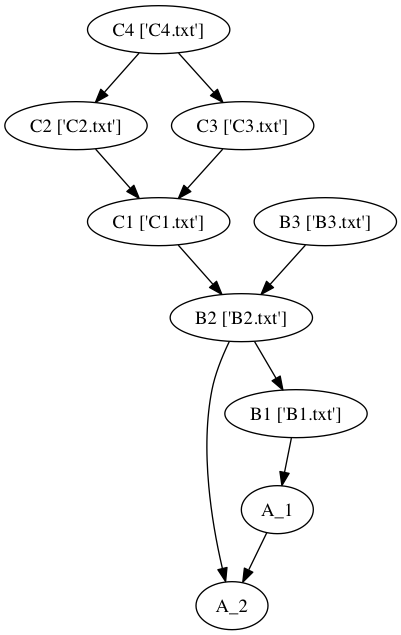

> dag_2.dot (340 B):

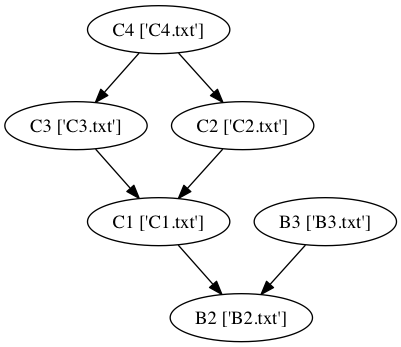

In [1]:
%sandbox --dir temp
%preview dag.dot dag_2.dot

!rm -f A?.txt B?.txt C?.txt
%run  -t B2.txt C2.txt -d dag
[A_1]
input: 'B1.txt'
output: 'A1.txt'
sh:
    touch A1.txt

[A_2]
depends:  'B2.txt'
sh:
    touch A2.txt

[B1: provides='B1.txt']
depends: 'B2.txt'
sh:
    touch B1.txt

[B2: provides='B2.txt']
depends: 'B3.txt', 'C1.txt'
sh:
    touch B2.txt

[B3: provides='B3.txt']
sh:
    touch B3.txt

[C1: provides='C1.txt']
depends: 'C2.txt', 'C3.txt'
sh:
    touch C1.txt

[C2: provides='C2.txt']
depends: 'C4.txt'
sh:
    touch C2.txt

[C3: provides='C3.txt']
depends: 'C4.txt'
sh:
    touch C3.txt

[C4: provides='C4.txt']
sh:
    touch C4.txt


The `-d` option produced two `.dot` files that can be converted to png format using `dot` command (e.g. `dot dag.dot -T png > dag.png`) but here we use the `%preview` magic to display them directory.

As you might have guessed, the first DAG is the complete DAG created from the workflow, and the second DAG is the trimmed down DAG that produces targets `B2.txt` and `C2.txt`. In real world applications, the DAG might grow with additional auxiliary steps if some input or dependency files are unavailable.

In [8]:
# Clean up
!rm -rf temp